## Original Data

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn.datasets as d
import sklearn.model_selection as ms
import sklearn.metrics as mt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydot  #graphviz의 dot language 와의 인터페이스를 제공하는 패키지 임포트
from IPython.display import Image #IPython의 display와 관련된 Pulbic API
import pydotplus
import graphviz

# 글씨체 보이기
plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## 데이터 전처리

In [4]:
# 데이터 불러오기
data = '/Users/jeong-yong/Desktop/데마/팀플/departure_data.csv'
df = pd.read_csv(data)

In [5]:
# 취소 데이터 확인하기
df.loc[(df['현황'] == '취소') & (df['사유'] == '태풍'), '현황'] = '기상 취소'
cancel_rows = df[df['현황'] == '취소']
reason_counts = cancel_rows['사유'].value_counts()
print(reason_counts)

# 지연 데이터 확인하기
delay_rows = df[df['현황'] == '지연']
reason_counts = cancel_rows['사유'].value_counts()
print(reason_counts)

df['최저운고'].fillna(0, inplace=True)
df['강수량(mm)'].fillna(0, inplace=True)
df['현황'].fillna('출발', inplace=True)

# 기상 취소, 기상 지연의 이유가 아닌 행들을 삭제하는 코드
# 취소에 사유가 없는 열 삭제
df = df[(df['현황'] != '취소')]
# 지연에 사유가 없는 열 삭제
df = df[(df['현황'] != '지연') | (df['사유'].notna())]
# 회항, 기상회항 삭제
df = df[(df['현황'] != '회항')]
df = df[(df['현황'] != '기상 회항')]

# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf = df[selected]
sdf

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


온도    시정  전운량  최저운고  풍속  강수량(mm)  현황
0       0.2   450    2  30.0   2      0.0  출발
1       0.2   450    2  30.0   2      0.0  출발
2       0.2   450    2  30.0   2      0.0  출발
3       0.2   450    2  30.0   2      0.0  출발
4       0.2   450    2  30.0   2      0.0  출발
...     ...   ...  ...   ...  ..      ...  ..
585021 -4.1  1000    8  30.0   3      0.0  출발
585022 -4.1  1000    8  30.0   3      0.0  출발
585023 -4.1  1000    8  30.0   3      0.0  출발
585024 -4.1  1000    8  30.0   3      0.0  출발
585025 -4.1  1000    8  30.0   3      0.0  출발

[538124 rows x 7 columns]

In [6]:
print(sdf['현황'].value_counts())

현황
출발       532733
기상 지연      4918
기상 취소       473
Name: count, dtype: int64


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

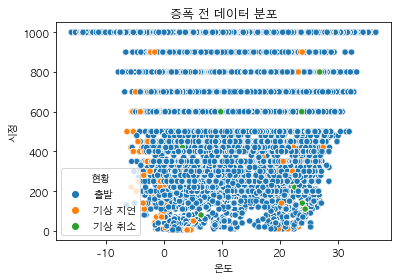

In [7]:
sns.scatterplot(data=sdf, x=sdf.iloc[:, 0], y=sdf.iloc[:, 1], hue='현황')
plt.title("증폭 전 데이터 분포")
plt.savefig('/Users/jeong-yong/Desktop/데마/팀플/증폭 전 데이터 분포.png')

In [8]:
# '현황' 기준으로 클래스 분포 확인
class_counts = sdf['현황'].value_counts()
print("기존 라벨 분포도:")
print(class_counts)

# Borderline-SMOTE 적용
X = sdf.drop(['현황'], axis=1)  # 입력 변수
y = sdf['현황']  # 타겟 변수

# Borderline-SMOTE 객체 생성
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)

# 데이터 증강
X_resampled, y_resampled = smote.fit_resample(X, y)

# 증강된 데이터프레임 생성
sdf_resampled = pd.DataFrame(X_resampled, columns=X.columns)
sdf_resampled['현황'] = y_resampled

# 증강된 클래스 분포 확인
resampled_class_counts = sdf_resampled['현황'].value_counts()
print("\nResampled Class Distribution:")
print(resampled_class_counts)

기존 라벨 분포도:
현황
출발       532733
기상 지연      4918
기상 취소       473
Name: count, dtype: int64


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD


Resampled Class Distribution:
현황
출발       532733
기상 지연    532733
기상 취소    532733
Name: count, dtype: int64


In [11]:
sdf_resampled

온도    시정  전운량        최저운고  풍속   강수량(mm)     현황
0         0.200000   450    2   30.000000   2  0.000000     출발
1         0.200000   450    2   30.000000   2  0.000000     출발
2         0.200000   450    2   30.000000   2  0.000000     출발
3         0.200000   450    2   30.000000   2  0.000000     출발
4         0.200000   450    2   30.000000   2  0.000000     출발
...            ...   ...  ...         ...  ..       ...    ...
1598194  25.871466  1000    7   13.213352  10  0.178665  기상 취소
1598195  12.552068   600    8   16.737332  13  0.815667  기상 취소
1598196   4.390175    11    7    1.000000   3  0.000000  기상 취소
1598197   4.732089   500    0    0.007568   6  0.000000  기상 취소
1598198  24.463960  1000    2  180.000000   5  0.000000  기상 취소

[1598199 rows x 7 columns]

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

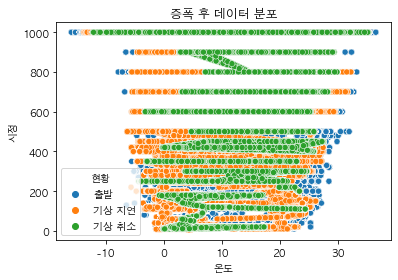

In [10]:
sns.scatterplot(data=sdf_resampled, x=sdf_resampled.iloc[:, 0], y=sdf_resampled.iloc[:, 1], hue='현황')
plt.title("증폭 후 데이터 분포")
plt.savefig('/Users/jeong-yong/Desktop/데마/팀플/증폭 후 데이터 분포.png')

In [8]:
X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1118739, 6) (479460, 6) (1118739,) (479460,)


## Original Decision Tree

In [9]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf = DecisionTreeClassifier(random_state = 33)
parameters = {'max_depth': [10, 15, 20, 25, 30],
              'min_samples_split': [2,4,8,16, 32, 64, 128, 256, 512],
              'splitter': ['best', 'random']}

grid_dt = GridSearchCV(dt_clf, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_dt.fit(X_test, y_test)

result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

max_depth  min_samples_split splitter  mean_test_score
72         30                  2     best         0.972000
74         30                  4     best         0.971649
73         30                  2   random         0.970029
76         30                  8     best         0.969505
75         30                  4   random         0.969355
..        ...                ...      ...              ...
11         10                 64   random         0.714986
7          10                 16   random         0.714911
5          10                  8   random         0.714299
17         10                512   random         0.710322
13         10                128   random         0.709223

[90 rows x 4 columns]

In [10]:
best_params = {'max_depth' : 25, 'min_samples_split': 2, 'splitter': 'best'}

#최적 파라미터 조합으로 DecisionTreeClassifier 초기화
best_dt = DecisionTreeClassifier(**best_params)

#최적모델로 학습
best_dt.fit(X_test, y_test)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

DecisionTreeClassifier(max_depth=25)

In [12]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_dt, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_dt, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

교차검증 평균:  0.885364087135421


In [11]:
#학습결과평가
from sklearn.metrics import classification_report
best_dt.fit(X_test, y_test)
predict_dt = best_dt.predict(X_test)
print(classification_report(y_test, predict_dt, zero_division=0))
accuracy = accuracy_score(y_test, predict_dt)
print("Accuracy of Decision Tree: ", accuracy)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

              precision    recall  f1-score   support

       기상 지연       0.98      0.98      0.98    159922
       기상 취소       0.98      0.99      0.99    159874
          출발       0.99      0.98      0.98    159664

    accuracy                           0.98    479460
   macro avg       0.98      0.98      0.98    479460
weighted avg       0.98      0.98      0.98    479460



/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

Accuracy of Decision Tree:  0.9818441580110958


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Original RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier

##### Hyper Parameter Tuning - GridSearch

In [21]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
rfB = RandomForestClassifier(random_state = 0)

parameters = {'n_estimators': [120, 130, 140, 150],
              'min_samples_split': [4,8],
              'max_depth' : [10, 20, 30, 40],
              }

grid_rfB = GridSearchCV(rfB, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_rfB.fit(X_test, y_test)

result = pd.DataFrame(grid_rfB.cv_results_['params'])
result['mean_test_score'] = grid_rfB.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

max_depth  min_samples_split  n_estimators  mean_test_score
17         30                  4           130         0.975101
19         30                  4           150         0.975097
18         30                  4           140         0.975093
16         30                  4           120         0.975078
25         40                  4           130         0.974619
24         40                  4           120         0.974603
27         40                  4           150         0.974601
26         40                  4           140         0.974588
22         30                  8           140         0.973531
21         30                  8           130         0.973489
23         30                  8           150         0.973481
20         30                  8           120         0.973470
31         40                  8           150         0.973307
29         40                  8           130         0.973253
30         40                  8           140         0.973232
28         40                  8           120         0.973230
11         20                  4           150         0.967858
10         20                  4           140         0.967762
9          20                  4           130         0.967689
8          20                  4           120         0.967689
14         20                  8           140         0.966208
15         20                  8           150         0.966202
13         20                  8           130         0.966051
12         20                  8           120         0.966037
2          10                  4           140         0.826336
3          10                  4           150         0.826086
0          10                  4           120         0.825668
1          10                  4           130         0.825577
6          10                  8           140         0.824836
5          10                  8           130         0.824811
4          10                  8           120         0.824805
7          10                  8           150         0.824152

In [22]:
best_params_rf = {'n_estimators' : 130, 'min_samples_split': 4, 'max_depth' : 30}

#최적 파라미터 조합으로 RandomForestClassifier 초기화
best_rf = RandomForestClassifier(**best_params_rf)

#최적모델로 학습
best_rf.fit(X_test, y_test)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

RandomForestClassifier(max_depth=30, min_samples_split=4, n_estimators=130)

In [23]:
#학습결과평가
from sklearn.metrics import classification_report
predict2 = best_rf.predict(X_test)
print(classification_report(y_test, predict2, zero_division=0))
#예측값저장
print('Accuracy of Random Forest:', accuracy_score(y_test,predict2)) 

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

              precision    recall  f1-score   support

       기상 지연       0.98      0.98      0.98    159922
       기상 취소       0.98      1.00      0.99    159874
          출발       1.00      0.98      0.99    159664

    accuracy                           0.99    479460
   macro avg       0.99      0.99      0.99    479460
weighted avg       0.99      0.99      0.99    479460



/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

Accuracy of Random Forest: 0.9864597672381429


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [24]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_rf, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_rf, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

교차검증 평균:  0.9077205043849116


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Original Multinomial Logistic Regression

In [26]:
X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools

In [29]:
# 테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2']}

# 테스트와 훈련 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_mlr = GridSearchCV(mlr, param_grid=parameters, cv=5)
grid_mlr.fit(X_train_scaled, y_train)

# 결과를 DataFrame으로 표시
result = pd.DataFrame(grid_mlr.cv_results_['params'])
result['mean_test_score'] = grid_mlr.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False, inplace=True)

# 결과 출력
print("Best Hyperparameters:", grid_mlr.best_params_)
print("GridSearchCV Results:\n", result)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
GridSearchCV Results:
         C penalty  mean_test_score
0   0.001      l2         0.595813
1   0.010      l2         0.595676
2   0.100      l2         0.595670
3   1.000      l2         0.595669
4  10.000      l2         0.595669


In [30]:
# 최적의 하이퍼파라미터로 모델 생성
best_mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga', max_iter = 1000, C=0.001, penalty='l2')
best_mlr.fit(X_train_scaled, y_train)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression(C=0.001, max_iter=1000, multi_class='multinomial',
                   random_state=42, solver='saga')

In [31]:
# 교차검증
from sklearn.model_selection import cross_val_score, cross_validate

# 교차 검증 수행
scores = cross_val_score(best_mlr, X, y, cv=5)
cv_results = cross_validate(best_mlr, X, y, cv=5)

print('교차검증 평균: ', scores.mean())
pd.DataFrame(cv_results)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

교차검증 평균:  0.57977385229484


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


fit_time  score_time  test_score
0  57.936693    0.299880    0.582139
1  60.605700    0.325342    0.582505
2  58.407410    0.307639    0.562899
3  61.001570    0.299367    0.600588
4  59.890293    0.302531    0.570738

In [32]:
# 학습 결과 평가
from sklearn.metrics import classification_report, accuracy_score

best_mlr.fit(X_test_scaled, y_test)
predict_mlr = best_mlr.predict(X_test_scaled)
print(classification_report(y_test, predict_mlr, zero_division=0))
accuracy = accuracy_score(y_test, predict_mlr)
print("Accuracy of Multinomial Logistic Regression: ", accuracy)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

              precision    recall  f1-score   support

       기상 지연       0.61      0.63      0.62    159922
       기상 취소       0.58      0.63      0.61    159874
          출발       0.60      0.53      0.56    159664

    accuracy                           0.60    479460
   macro avg       0.60      0.60      0.60    479460
weighted avg       0.60      0.60      0.60    479460



/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

Accuracy of Multinomial Logistic Regression:  0.5973240729153632


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Sampling 20,000 Data

In [12]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn.datasets as d
import sklearn.model_selection as ms
import sklearn.metrics as mt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydot  #graphviz의 dot language 와의 인터페이스를 제공하는 패키지 임포트
from IPython.display import Image #IPython의 display와 관련된 Pulbic API
import pydotplus
import graphviz

# 글씨체 보이기
plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [13]:
# 데이터 불러오기
data = '/Users/jeong-yong/Desktop/데마/팀플/departure_data.csv'
df = pd.read_csv(data)

##### Sampling 20,000

In [14]:
# 취소 데이터 확인하기
df.loc[(df['현황'] == '취소') & (df['사유'] == '태풍'), '현황'] = '기상 취소'
cancel_rows = df[df['현황'] == '취소']
reason_counts = cancel_rows['사유'].value_counts()

# 지연 데이터 확인하기
delay_rows = df[df['현황'] == '지연']
reason_counts = cancel_rows['사유'].value_counts()

df['최저운고'].fillna(0, inplace=True)
df['강수량(mm)'].fillna(0, inplace=True)
df['현황'].fillna('출발', inplace=True)

# 기상 취소, 기상 지연의 이유가 아닌 행들을 삭제하는 코드
# 취소에 사유가 없는 열 삭제
df = df[(df['현황'] != '취소')]
# 지연에 사유가 없는 열 삭제
df = df[(df['현황'] != '지연') | (df['사유'].notna())]
# 회항, 기상회항 삭제
df = df[(df['현황'] != '회항')]
df = df[(df['현황'] != '기상 회항')]

# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf = df[selected]
sdf

온도    시정  전운량  최저운고  풍속  강수량(mm)  현황
0       0.2   450    2  30.0   2      0.0  출발
1       0.2   450    2  30.0   2      0.0  출발
2       0.2   450    2  30.0   2      0.0  출발
3       0.2   450    2  30.0   2      0.0  출발
4       0.2   450    2  30.0   2      0.0  출발
...     ...   ...  ...   ...  ..      ...  ..
585021 -4.1  1000    8  30.0   3      0.0  출발
585022 -4.1  1000    8  30.0   3      0.0  출발
585023 -4.1  1000    8  30.0   3      0.0  출발
585024 -4.1  1000    8  30.0   3      0.0  출발
585025 -4.1  1000    8  30.0   3      0.0  출발

[538124 rows x 7 columns]

In [15]:
# 데이터프레임에서 "출발"인 값을 가진 행을 추출
departure_data = sdf[sdf['현황'] == "출발"]

# 랜덤하게 20,000개 추출
random_selected_data = departure_data.sample(n=20000, random_state=42)

# 지연 데이터 와 취소 데이터 추출하기
delay_data = sdf[sdf['현황'] == "기상 지연"]
cancel_data = sdf[sdf['현황'] == '기상 취소']

new = [random_selected_data, delay_data, cancel_data]

# 데이터프레임들을 수직 방향으로 합치기
sdf = pd.concat(new, axis=0, ignore_index=True)
sdf
print(sdf['현황'].value_counts())

현황
출발       20000
기상 지연     4918
기상 취소      473
Name: count, dtype: int64


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

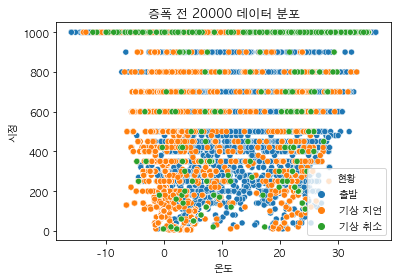

In [16]:
sns.scatterplot(data=sdf, x=sdf.iloc[:, 0], y=sdf.iloc[:, 1], hue='현황')
plt.title("증폭 전 20000 데이터 분포")
plt.savefig('/Users/jeong-yong/Desktop/데마/팀플/증폭 전 20,000 데이터 분포.png')

#### borderline smote로 각 항목의 출발,기상지연,기상취소를 20,000개로 세팅

In [17]:
# '현황' 기준으로 클래스 분포 확인
class_counts = sdf['현황'].value_counts()
print("기존 라벨 분포도:")
print(class_counts)

# Borderline-SMOTE 적용
X = sdf.drop(['현황'], axis=1)  # 입력 변수
y = sdf['현황']  # 타겟 변수

# Borderline-SMOTE 객체 생성
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)

# 데이터 증강
X_resampled, y_resampled = smote.fit_resample(X, y)

# 증강된 데이터프레임 생성
sdf_resampled = pd.DataFrame(X_resampled, columns=X.columns)
sdf_resampled['현황'] = y_resampled

# 증강된 클래스 분포 확인
resampled_class_counts = sdf_resampled['현황'].value_counts()
print("\nResampled Class Distribution:")
print(resampled_class_counts)

기존 라벨 분포도:
현황
출발       20000
기상 지연     4918
기상 취소      473
Name: count, dtype: int64


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD


Resampled Class Distribution:
현황
출발       20000
기상 지연    20000
기상 취소    20000
Name: count, dtype: int64


In [18]:
sdf_resampled

온도    시정  전운량        최저운고  풍속  강수량(mm)     현황
0      13.100000  1000    7  120.000000   7      0.0     출발
1      14.000000   350    2   20.000000   7      0.0     출발
2      28.400000  1000    8   10.000000  10      0.0     출발
3      17.200000  1000    4   40.000000  16      0.0     출발
4      -4.000000  1000    0    0.000000  10      0.0     출발
...          ...   ...  ...         ...  ..      ...    ...
59995  28.900000  1000    8   40.000000  25      0.0  기상 취소
59996  27.451221  1000    1   30.000000  15      0.0  기상 취소
59997  26.969719  1000    5   45.000000   7      0.0  기상 취소
59998   2.163191  1000    3   96.505527   3      0.0  기상 취소
59999   4.740469    51    7    1.342411   1      0.0  기상 취소

[60000 rows x 7 columns]

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

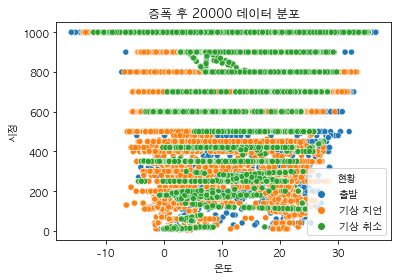

In [19]:
sns.scatterplot(data=sdf_resampled, x=sdf_resampled.iloc[:, 0], y=sdf_resampled.iloc[:, 1], hue='현황')
plt.title("증폭 후 20000 데이터 분포")
plt.savefig('/Users/jeong-yong/Desktop/데마/팀플/증폭 후 20000 데이터 분포.png')

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

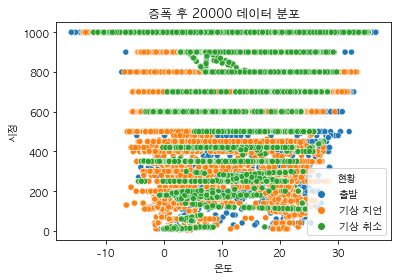

In [20]:
sns.scatterplot(data=sdf_resampled, x=sdf_resampled.iloc[:, 0], y=sdf_resampled.iloc[:, 1], hue='현황')
plt.title("증폭 후 20000 데이터 분포")
plt.savefig('/Users/jeong-yong/Desktop/데마/팀플/증폭 후 20000 데이터 분포.png')

In [22]:
X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42000, 6) (18000, 6) (42000,) (18000,)


## 20,000 Decision Tree

In [23]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf = DecisionTreeClassifier(random_state = 33)
parameters = {'max_depth': [10, 15, 20, 25, 30],
              'min_samples_split': [2,4,8,16, 32, 64, 128, 256, 512],
              'splitter': ['best', 'random']}

grid_dt = GridSearchCV(dt_clf, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_dt.fit(X_test, y_test)

result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

max_depth  min_samples_split splitter  mean_test_score
54         25                  2     best         0.786000
72         30                  2     best         0.785222
73         30                  2   random         0.783611
55         25                  2   random         0.783556
36         20                  2     best         0.782444
..        ...                ...      ...              ...
35         15                512   random         0.596889
71         25                512   random         0.596889
53         20                512   random         0.596889
89         30                512   random         0.596889
17         10                512   random         0.593944

[90 rows x 4 columns]

In [24]:
best_params = {'max_depth' : 25, 'min_samples_split': 2, 'splitter': 'best'}

#최적 파라미터 조합으로 DecisionTreeClassifier 초기화
best_dt = DecisionTreeClassifier(**best_params)

#최적모델로 학습
best_dt.fit(X_test, y_test)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

DecisionTreeClassifier(max_depth=25)

In [25]:
#학습결과평가
from sklearn.metrics import classification_report
best_dt.fit(X_test, y_test)
predict_dt = best_dt.predict(X_test)
print(classification_report(y_test, predict_dt, zero_division=0))
accuracy = accuracy_score(y_test, predict_dt)
print("Accuracy of Decision Tree: ", accuracy)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

              precision    recall  f1-score   support

       기상 지연       0.97      0.99      0.98      5862
       기상 취소       0.99      1.00      0.99      6134
          출발       0.99      0.96      0.98      6004

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000

Accuracy of Decision Tree:  0.9831666666666666


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [26]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_dt, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_dt, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

교차검증 평균:  0.83145


/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fu

## 20,000 RandomForest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
rfB = RandomForestClassifier(random_state = 0)

parameters = {'n_estimators': [120, 130, 140, 150],
              'min_samples_split': [4,8],
              'max_depth' : [10, 20, 30, 40],
              }

grid_rfB = GridSearchCV(rfB, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_rfB.fit(X_test, y_test)

result = pd.DataFrame(grid_rfB.cv_results_['params'])
result['mean_test_score'] = grid_rfB.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jeong-yong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [ ]:
best_params_rf = {'n_estimators' : 120, 'min_samples_split': 4, 'max_depth' : 30}

#최적 파라미터 조합으로 RandomForestClassifier 초기화
best_rf = RandomForestClassifier(**best_params_rf)

#최적모델로 학습
best_rf.fit(X_test, y_test)

In [ ]:
#학습결과평가
from sklearn.metrics import classification_report
predict2 = best_rf.predict(X_test)
print(classification_report(y_test, predict2, zero_division=0))
#예측값저장
print('Accuracy of Random Forest:', accuracy_score(y_test,predict2)) 

In [ ]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_rf, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_rf, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

## 20,000 Original Multinomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools

In [ ]:
X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']

In [ ]:
# 테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2']}

# 테스트와 훈련 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_mlr = GridSearchCV(mlr, param_grid=parameters, cv=5)
grid_mlr.fit(X_train_scaled, y_train)

# 결과를 DataFrame으로 표시
result = pd.DataFrame(grid_mlr.cv_results_['params'])
result['mean_test_score'] = grid_mlr.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False, inplace=True)

# 결과 출력
print("Best Hyperparameters:", grid_mlr.best_params_)
print("GridSearchCV Results:\n", result)

In [ ]:
# 최적의 하이퍼파라미터로 모델 생성
best_mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga', max_iter = 1000, C=0.001, penalty='l2')
best_mlr.fit(X_train_scaled, y_train)

In [ ]:
# 교차검증
from sklearn.model_selection import cross_val_score, cross_validate

# 교차 검증 수행
scores = cross_val_score(best_mlr, X, y, cv=5)
cv_results = cross_validate(best_mlr, X, y, cv=5)

print('교차검증 평균: ', scores.mean())
pd.DataFrame(cv_results)

In [ ]:
# 학습 결과 평가
from sklearn.metrics import classification_report, accuracy_score

best_mlr.fit(X_test_scaled, y_test)
predict_mlr = best_mlr.predict(X_test_scaled)
print(classification_report(y_test, predict_mlr, zero_division=0))
accuracy = accuracy_score(y_test, predict_mlr)
print("Accuracy of Multinomial Logistic Regression: ", accuracy)